In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import SVG, display

%matplotlib inline

# Positional Encoding

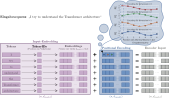

In [2]:
display(SVG(filename='../latex/figures/TransformerVisualization.svg'))

This notebook is intended to complement the project report and help develop an understanding of positional encoding. While the sinusoidal and cosine wave illustrations presented in the report were drawn arbitrarily to facilitate easier intuition (one can directly observe that the wavelengths of the functions increase with rising dimension `i`), the following will depict the positional encodings as they would actually appear based on the example *"I try to understand the Transformer architecture"*. For this purpose, the parameters have already been configured so that the notebook runs to display the sine and cosine functions of different frequencies as they would actually appear based on the example. However, the interested user is encouraged to experiment with the parameters. To facilitate this, the following accordion is provided:

### Choose parameters

In [3]:
parameter_list = ['d_model', 'd_vis', 'seq_len', 'n']
description_list = [
    "Value for d_model (the dimensionality of the model's hidden states and embeddings)",
    "Number of dimensions to visualize",
    "Sequence length (typically the length of the longest sentence in the training set incl. special tokens)",
    "Length of the current input sentence"]
value_list = [512, 6, 7, 7]
children = [widgets.IntText(value=value, description=f"{param}: ") for param, value in zip(parameter_list, value_list)]
accordions = widgets.Accordion(children, titles=(*description_list,))
d_model = accordions.children[0].value
d_vis = accordions.children[1].value
seq_len = accordions.children[2].value
n = accordions.children[3].value
accordions

Accordion(children=(IntText(value=512, description='d_model: '), IntText(value=6, description='d_vis: '), IntT…

**Regarding the choice of parameters:**
* A model dimension of $d_{\text{model}}=512$ was selected because this specific numerical value is used in the "Attention Is All You Need" paper and, consequently, in the project report. However, other Transformer variants also experiment with different dimensions.
* $d_{\text{vis}}$ is not a model parameter. It simply specifies the number of dimensions of the encoding vector for which a function is to be plotted, allowing for a better understanding of how the individual values of the positional encoding matrix are derived.
* The sequence length ($seq\_len$) is indeed a model parameter that needs to be set at the beginning of Transformer training. This is because the weight matrices in the Transformer always have a fixed size, and we cannot simply resize them for different sentences. In the project report, for the sake of clarity, only this length was mentioned, and for visualizations, we limited it to the length of the current input sentence. Typically, one would choose the length of the longest sentence in the training dataset. For more information, please refer to my separate notebook on input embedding titled *"transformers_embedding.ipynb"*.
* A length of $n=7$ for the input sentence *"I try to understand the transformer architecture"* (neglecting the special tokens).

### Calculate the positional encoding
Here's a brief recap:

There are various ways to perform positional encodings (both learned and fixed). The authors of the "Attention Is All You Need" paper chose to use sine and cosine functions of different frequencies for this purpose, and they employed the following formulas:
\begin{equation}\label{eq:PosEncode}
	\begin{aligned}
		PE_{pos,2i} &= \sin\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)\\
		PE_{pos,2i+1} &= \cos\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)
	\end{aligned}
\end{equation}
Here, `pos` refers to the position, and `i` denotes the (hidden) dimension that represents a specific location withing the positoinal encoding vector of length $d_{model}$. Therefore, the authors distinguish between even and uneven hidden dimensionalities where they apply a sine/cosine resprectively. From the formulas, it can be observed that the wavelengths of the functions become wider as the dimensions `i` increase.

In the following code block, the positional encoding is computed:

In [4]:
# Create a matrix of shape (d_model, seq_len)
pe = np.zeros((d_model, seq_len), dtype=np.float32)
# Create a vector of shape (seq_len)
position = np.arange(seq_len, dtype=np.float32).reshape(-1, 1)
# Create a vector of shape (d_model)
div_term = np.exp(np.arange(0, d_model, 2, dtype=np.float32) * (-math.log(10000.0) / d_model))  # (d_model / 2)
# Apply sine to even indices
pe[0::2, :] = np.sin(position * div_term).T  # sin(position * (10000 ** (2i / d_model))
# Apply cosine to odd indices
pe[1::2, :] = np.cos(position * div_term).T  # cos(position * (10000 ** (2i / d_model))

*Note:* </br>
For those who were very attentive, you may have noticed that the formulas here were implemented with slight modifications. This was done as I came across some changes online for numerical stability, and I implemented them in the same way using `exp` and `log`.

### Visualize the positional encoding
Now that we've computed the positional encoding, we can visualize it. Below, the computed values of the positional encoding vectors for each position of a word in the input sequence are illustrated for the $d_{vis}$ dimensions chosen by the user. By default, $d_{vis}=6$. The word *"I"* is the first in the input sequence and is therefore at position $i=0$. The positional encoding vector for the word *"I"* is filled with the 6 values highlighted by colorful circles at position $0$. Similarly, the vector for the word *"try"* is filled with values at position $i=1$ and so on. This ultimately results in the positional encoding matrix of size $(n, d_{model})$, as illustrated in the image above by the blue rectangle.

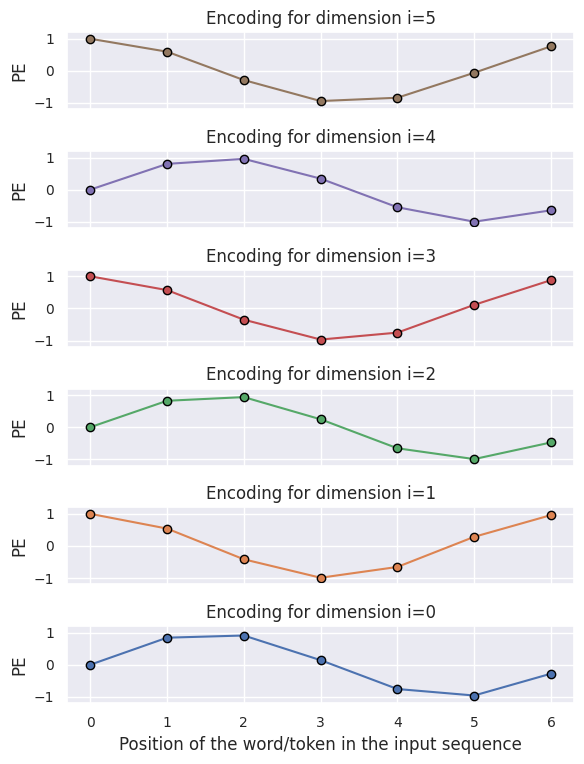

In [5]:
sns.set_theme()
fig, axs = plt.subplots(d_vis, 1, figsize=(6, 1.3 * d_vis), sharex='all', sharey='all')
for i in range(d_vis):
    axs[d_vis - 1 - i].plot(np.arange(n), pe[i, :n], color=f'C{i}', marker="o", markersize=6, markeredgecolor="black")
    axs[d_vis - 1 - i].set_title(f'Encoding for dimension i={i}')
    axs[d_vis - 1 - i].set_ylabel('PE', fontsize=12)
    axs[d_vis - 1 - i].set_xticks(np.arange(n))
    axs[d_vis - 1 - i].tick_params(axis='both', which='major', labelsize=10)
    axs[d_vis - 1 - i].tick_params(axis='both', which='minor', labelsize=8)
    axs[d_vis - 1 - i].set_ylim(-1.2, 1.2)
axs[-1].set_xlabel('Position of the word/token in the input sequence', fontsize=12)
fig.tight_layout()

So far, so good. However, in the report, it was explained that the wavelengths increase as the dimension `i` increases. Here, though, every second plot looks the same. Have we done something wrong, and are the positional encoding vectors of individual words/tokens no longer unique?

No! All the calculations are correct. If you look very closely, you can see small differences in the values when using the white grid as a reference. However, since we have `512` dimensions in this example, the widening of the wavelengths is not immediately noticeable to the naked eye. So, let's simplify things and take the same code from above, but modify it so that it doesn't plot the first $d_{vis}$ dimensions but instead the last ones.

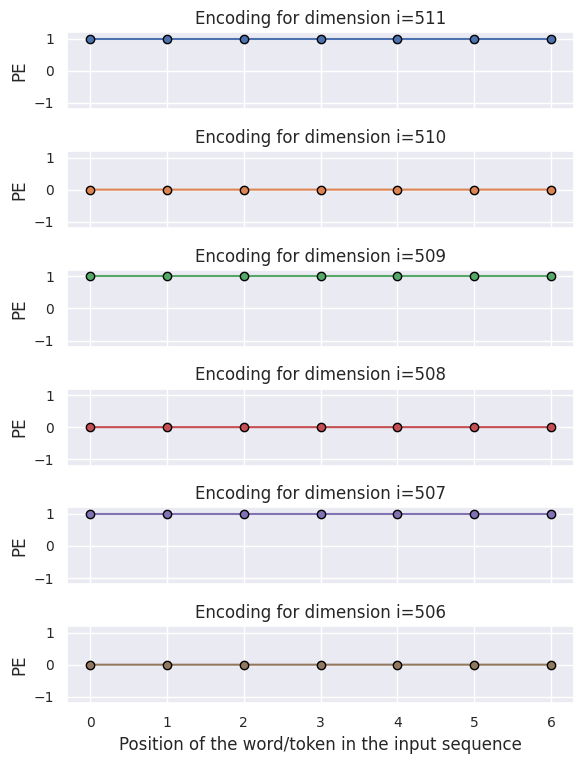

In [6]:
fig, axs = plt.subplots(d_vis, 1, figsize=(6, 1.3 * d_vis), sharex='all', sharey='all')
for i in range(d_vis):
    axs[i].plot(np.arange(n), pe[-(i+1), :n], color=f'C{i}', marker="o", markersize=6, markeredgecolor="black")
    axs[i].set_title(f'Encoding for dimension i={d_model-(i+1)}')
    axs[i].set_ylabel('PE', fontsize=12)
    axs[i].set_xticks(np.arange(n))
    axs[i].tick_params(axis='both', which='major', labelsize=10)
    axs[i].tick_params(axis='both', which='minor', labelsize=8)
    axs[i].set_ylim(-1.2, 1.2)
axs[-1].set_xlabel('Position of the word/token in the input sequence', fontsize=12)
fig.tight_layout()

This visualization of the values of the last $d_{vis}$ dimensions may initially appear incorrect since they now resemble approximate linear functions. However, in this case, the wavelength is so large that waves are no longer discernible.